# Ensemble Anomaly Detection

**Мета:** Об'єднати результати всіх методів в єдиний risk score.

**Методи (5 рівнів):**
1. Rule-based (44 rules) — процедурні порушення
2. Statistical (Benford, Z-score) — числові аномалії
3. Isolation Forest — глобальні outliers
4. HDBSCAN — кластеризація + outlier detection
5. Network Analysis — мережевий аналіз (картелі, монополії)

**Ensemble підхід:**
- Weighted voting: кожен метод голосує з вагою
- Consensus: скільки методів flagged тендер
- Final risk score: нормалізована комбінація

**Pipeline:**
1. Rule-based ✓
2. Statistical ✓
3. Isolation Forest ✓
4. HDBSCAN ✓
5. Network ✓
6. **Ensemble** ← current

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import load_tenders, load_bids, load_buyers, load_suppliers, load_bidders
from src.detectors import (
    RuleBasedDetector,
    StatisticalDetector,
    PyODDetector,
    HDBSCANDetector,
    NetworkAnalysisDetector,
    EnsembleDetector,
)

# ============================================================
# CONFIGURATION
# ============================================================
YEARS = [2022, 2023, 2024, 2025]
CONTAMINATION = 0.05
HDBSCAN_SAMPLE_SIZE = 1_000_000  # HDBSCAN on sample
# ============================================================

# Create output directories
Path('../results/figures/ensemble').mkdir(parents=True, exist_ok=True)
Path('../results').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Configuration: YEARS={YEARS}, CONTAMINATION={CONTAMINATION}")

Configuration: YEARS=[2022, 2023, 2024, 2025], CONTAMINATION=0.05


## 1. Завантаження даних

In [2]:
print("Loading data...")
tenders = load_tenders(years=YEARS)
bids = load_bids(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()
bidders = load_bidders()

print(f"\nDataset:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Bids: {len(bids):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")
print(f"  Bidders: {len(bidders):,}")

Loading data...
Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Scanning bids 2022...
Scanning bids 2023...
Scanning bids 2024...
Scanning bids 2025...
Loaded 2,639,473 bids
Loaded buyers: 35,995
Loaded suppliers: 358,376
Loaded bidders: 72,291

Dataset:
  Tenders: 12,877,960
  Bids: 2,639,473
  Buyers: 35,995
  Suppliers: 358,376
  Bidders: 72,291


## 2. Run All Detectors

In [3]:
# 1. Rule-based
print("="*60)
print("1. RULE-BASED DETECTOR")
print("="*60)
rule_detector = RuleBasedDetector()
rule_results = rule_detector.detect(tenders, buyers_df=buyers, bids_df=bids)
print(f"\nRule-based anomalies (score >= 6): {(rule_results['rule_risk_score'] >= 6).sum():,}")

1. RULE-BASED DETECTOR
Processing 12,877,960 tenders...
Step 1/4: Computing aggregations...
  Computing CPV stats...
  Computing buyer stats...
  Computing supplier stats...
  Computing pair stats...
  Aggregations complete.
Step 2/4: Merging reference data...
Step 3/4: Applying 44 rules...
  Applied 43 rules successfully.
Step 4/4: Computing risk levels and summary...
Detection complete!

Rule-based anomalies (score >= 6): 1,882,159


In [4]:
# 2. Statistical
print("="*60)
print("2. STATISTICAL DETECTOR")
print("="*60)
stat_detector = StatisticalDetector()
stat_results = stat_detector.detect(tenders, bids_df=bids)
print(f"\nStatistical anomalies (score >= 3): {(stat_results['stat_score'] >= 3).sum():,}")

2. STATISTICAL DETECTOR
Processing 12,877,960 tenders...
Step 1/5: Computing value outliers (Z-score, IQR)...
Step 2/5: Analyzing price patterns...
Step 3/5: Running Benford's Law analysis...
    Testing Benford per buyer...
    Buyers tested: 22,334, anomalies: 7,640
    Testing Benford per supplier...
    Suppliers tested: 72,202, anomalies: 1,992
Step 4/5: Analyzing bid spreads...
Step 5/5: Computing market concentration...
Statistical screening complete!

Statistical anomalies (score >= 3): 1,473,275


In [5]:
# 3. Isolation Forest (via PyODDetector)
print("="*60)
print("3. ISOLATION FOREST")
print("="*60)

if_detector = PyODDetector(
    algorithm="iforest",
    contamination=CONTAMINATION,
    random_state=42,
)
if_results = if_detector.fit_detect(tenders, buyers_df=buyers, suppliers_df=suppliers)

# Rename columns for ensemble compatibility
if_results = if_results.rename(columns={"score": "if_score", "anomaly": "if_anomaly"})

print(f"IF anomalies: {if_results['if_anomaly'].sum():,}")


3. ISOLATION FOREST
PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (12877960, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 643,898 (5.00%)
IF anomalies: 643,898


In [6]:
# 4. HDBSCAN (on sample)
print("="*60)
print("4. HDBSCAN (sample)")
print("="*60)

hdbscan_detector = HDBSCANDetector(
    min_cluster_size=50,
    min_samples=10,
    contamination=CONTAMINATION,
)
hdbscan_results = hdbscan_detector.fit_detect(
    tenders, 
    buyers_df=buyers, 
    suppliers_df=suppliers,
    sample_size=HDBSCAN_SAMPLE_SIZE,
)
print(f"HDBSCAN anomalies: {hdbscan_results['hdbscan_anomaly'].sum():,}")


4. HDBSCAN (sample)
Processing 12,877,960 tenders...
  Sampling 1,000,000 tenders...
Step 1/4: Preparing features...
  Features: 14
Step 2/4: Preprocessing (impute + scale)...
  Shape: (1000000, 14)
Step 3/4: Fitting HDBSCAN...
Step 4/4: Computing results...

HDBSCAN complete!
  Clusters: 672
  Noise points: 608,721 (60.9%)
  Anomalies (top 5%): 609,171
HDBSCAN anomalies: 609,171


In [7]:
# 5. Network Analysis
print("="*60)
print("5. NETWORK ANALYSIS")
print("="*60)

network_detector = NetworkAnalysisDetector(
    min_co_bids=3,
    min_contracts=3,
    min_community_size=3,
    # Stricter anomaly thresholds to reduce false positives
    suspicious_min_degree=10,        # Was 5
    suspicious_min_clustering=0.7,   # Was 0.5
    rotation_min_ratio=0.7,          # Was 0.5
    rotation_min_interactions=5,     # New: at least 5 head-to-head competitions
    monopoly_min_ratio=0.9,          # Was 0.8
    monopoly_min_contracts=20,       # Was 10
)
network_results = network_detector.fit_detect(tenders, bids_df=bids, bidders_df=bidders)
print(f"\nNetwork anomalies: {network_results['network_anomaly'].sum():,}")

5. NETWORK ANALYSIS
Processing 12,877,960 tenders...
  Competitive tenders: 575,750
  Bids in competitive: 2,054,727

Step 1/4: Building co-bidding network...
    Nodes: 20,894
    Edges: 170,763
Step 2/4: Detecting communities...
    Using igraph (fast)...
    Communities: 837
Step 3/4: Building winner-loser network...
    Nodes: 15,633
    Edges: 95,300
    Bid rotation pairs: 13615
Step 4/4: Building buyer-supplier network...
    Nodes: 198,182
    Edges: 916,277
    Monopolistic pairs (>=80%, >=10 contracts): 172

Computing tender-level results...
    Suspicious suppliers: 1636
    Strict monopolistic pairs: 44
    Strict rotation pairs: 7962

Network Analysis complete!
  Tenders with network flags: 2,296,664

Network anomalies: 2,296,664


In [8]:
# Combine all results using EnsembleDetector
print("="*60)
print("COMBINING RESULTS WITH ENSEMBLE DETECTOR")
print("="*60)

ensemble_detector = EnsembleDetector(
    weights={
        'rule': 1.0,
        'stat': 0.8,
        'if': 1.0,
        'hdbscan': 0.8,
        'network': 1.0,
    },
    consensus_threshold=2,
)

ensemble = ensemble_detector.combine(
    rule_results=rule_results,
    stat_results=stat_results,
    if_results=if_results,
    hdbscan_results=hdbscan_results,
    network_results=network_results,
)

print(f"\nEnsemble dataset: {len(ensemble):,} tenders")

COMBINING RESULTS WITH ENSEMBLE DETECTOR
  Rule-based: 12,877,960 tenders
  Statistical: 12,877,960 tenders
  Isolation Forest: 12,877,960 tenders
  HDBSCAN: 1,000,000 tenders
  Network: 12,877,960 tenders

Combining 5 methods: ['rule', 'stat', 'if', 'hdbscan', 'network']

Ensemble complete!
  Critical (5/5 methods): 628
  High (2+/5 methods): 36,986

Ensemble dataset: 12,877,960 tenders


# Skip - EnsembleDetector handles normalization internally

In [9]:
# Scores are already normalized by EnsembleDetector
print("Score columns in ensemble results:")
print([col for col in ensemble.columns if 'score' in col])

Score columns in ensemble results:
['rule_score', 'stat_score', 'if_score', 'hdbscan_score', 'network_score', 'ensemble_score']


## 5. Compute Ensemble Score

In [10]:
# EnsembleDetector computes scores and consensus automatically
# ensemble_score, consensus_count, consensus_pct, ensemble_anomaly, ensemble_risk_level

print("WEIGHTS:", ensemble_detector.weights)
print(f"\nEnsemble score stats:")
print(ensemble['ensemble_score'].describe())

WEIGHTS: {'rule': 1.0, 'stat': 0.8, 'if': 1.0, 'hdbscan': 0.8, 'network': 1.0}

Ensemble score stats:
count    1.287796e+07
mean     1.024709e-01
std      8.055048e-02
min      8.820651e-05
25%      4.783851e-02
50%      7.433629e-02
75%      1.307799e-01
max      6.777363e-01
Name: ensemble_score, dtype: float64


In [11]:
# Risk levels are computed by EnsembleDetector
# Based on consensus_count: critical (>=75%), high (>=50%), medium (>=25%), low (<25%)

risk_dist = ensemble['ensemble_risk_level'].value_counts()
print("\nENSEMBLE RISK DISTRIBUTION:")
for level in ['critical', 'high', 'medium', 'low']:
    count = risk_dist.get(level, 0)
    pct = count / len(ensemble) * 100
    print(f"  {level:10} {count:>10,} ({pct:>5.2f}%)")


ENSEMBLE RISK DISTRIBUTION:
  critical          628 ( 0.00%)
  high           36,358 ( 0.28%)
  medium        507,278 ( 3.94%)
  low        12,333,696 (95.77%)


## 6. Consensus Analysis

In [12]:
# Consensus breakdown (5 methods)
n_methods = len(ensemble_detector.methods_used)
print(f"CONSENSUS BREAKDOWN ({n_methods} methods: {ensemble_detector.methods_used}):")

consensus_dist = ensemble['consensus_count'].value_counts().sort_index()
for count, num in consensus_dist.items():
    pct = num / len(ensemble) * 100
    methods = f"{count}/{n_methods} methods"
    print(f"  {methods}: {num:>10,} ({pct:>5.2f}%)")

# Critical: most methods agree
critical_threshold = int(n_methods * 0.75)  # 75%+ methods
critical_consensus = ensemble[ensemble['consensus_count'] >= critical_threshold]
print(f"\nCRITICAL ({critical_threshold}+ of {n_methods} methods): {len(critical_consensus):,} tenders")

CONSENSUS BREAKDOWN (5 methods: ['rule', 'stat', 'if', 'hdbscan', 'network']):
  0/5 methods:  9,809,891 (76.18%)
  1/5 methods:  2,523,805 (19.60%)
  2/5 methods:    507,278 ( 3.94%)
  3/5 methods:     36,358 ( 0.28%)
  4/5 methods:        624 ( 0.00%)
  5/5 methods:          4 ( 0.00%)

CRITICAL (3+ of 5 methods): 36,986 tenders


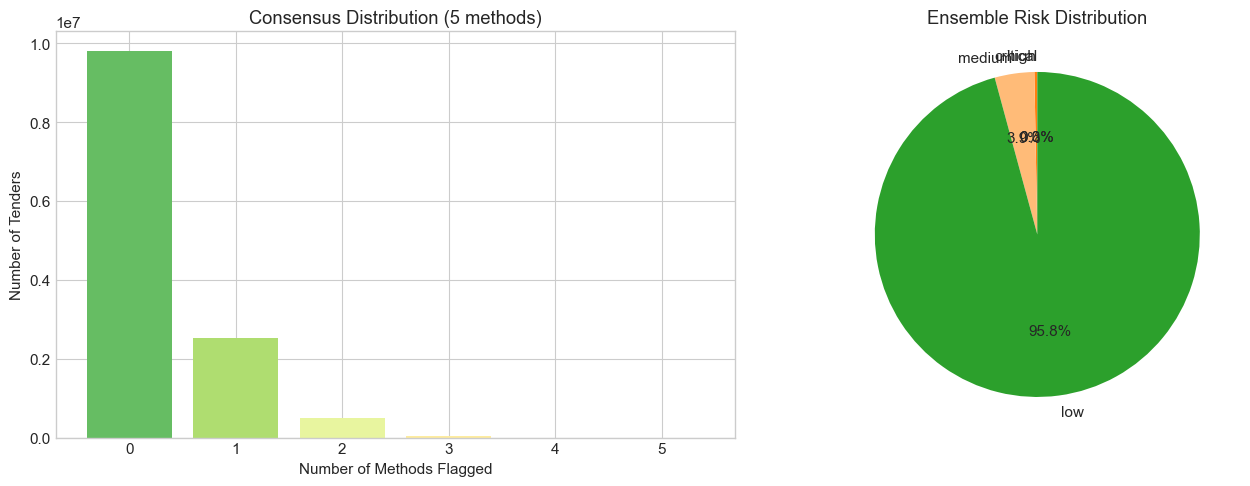

In [13]:
# Visualize consensus
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Consensus distribution
n_methods = len(ensemble_detector.methods_used)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, n_methods + 1))
axes[0].bar(consensus_dist.index, consensus_dist.values, color=colors[:len(consensus_dist)])
axes[0].set_xlabel('Number of Methods Flagged')
axes[0].set_ylabel('Number of Tenders')
axes[0].set_title(f'Consensus Distribution ({n_methods} methods)')
axes[0].set_xticks(range(n_methods + 1))

# Risk level pie
risk_colors = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#2ca02c'}
risk_order = ['critical', 'high', 'medium', 'low']
risk_values = [risk_dist.get(r, 0) for r in risk_order]
axes[1].pie(risk_values, labels=risk_order, colors=[risk_colors[r] for r in risk_order],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Ensemble Risk Distribution')

plt.tight_layout()
plt.savefig('../results/figures/ensemble/consensus_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Method Contribution Analysis

In [14]:
# Method contribution analysis using EnsembleDetector
print("METHOD STATISTICS:")
print(ensemble_detector.method_summary().to_string(index=False))

# Correlation matrix
print("\nSCORE CORRELATION MATRIX:")
corr_matrix = ensemble_detector.correlation_matrix()
print(corr_matrix.round(3).to_string())

# Agreement matrix (Jaccard similarity)
print("\nANOMALY AGREEMENT MATRIX (Jaccard):")
agreement_matrix = ensemble_detector.agreement_matrix()
print(agreement_matrix.round(3).to_string())

METHOD STATISTICS:
 method  anomalies  anomaly_pct  mean_score  median_score
   rule      95922     0.744854    0.150419      0.136364
   stat       4296     0.033359    0.053169      0.031250
     if     643898     5.000000    0.175640      0.118790
hdbscan     609171     4.730338    0.048931      0.000000
network    2296664    17.834067    0.063627      0.000000

SCORE CORRELATION MATRIX:
               rule_score  stat_score  if_score  hdbscan_score  network_score
rule_score          1.000       0.149     0.168          0.003          0.066
stat_score          0.149       1.000     0.504          0.005          0.217
if_score            0.168       0.504     1.000          0.041          0.345
hdbscan_score       0.003       0.005     0.041          1.000          0.006
network_score       0.066       0.217     0.345          0.006          1.000

ANOMALY AGREEMENT MATRIX (Jaccard):
                 rule_anomaly  stat_anomaly  if_anomaly  hdbscan_anomaly  network_anomaly
rule_anomal

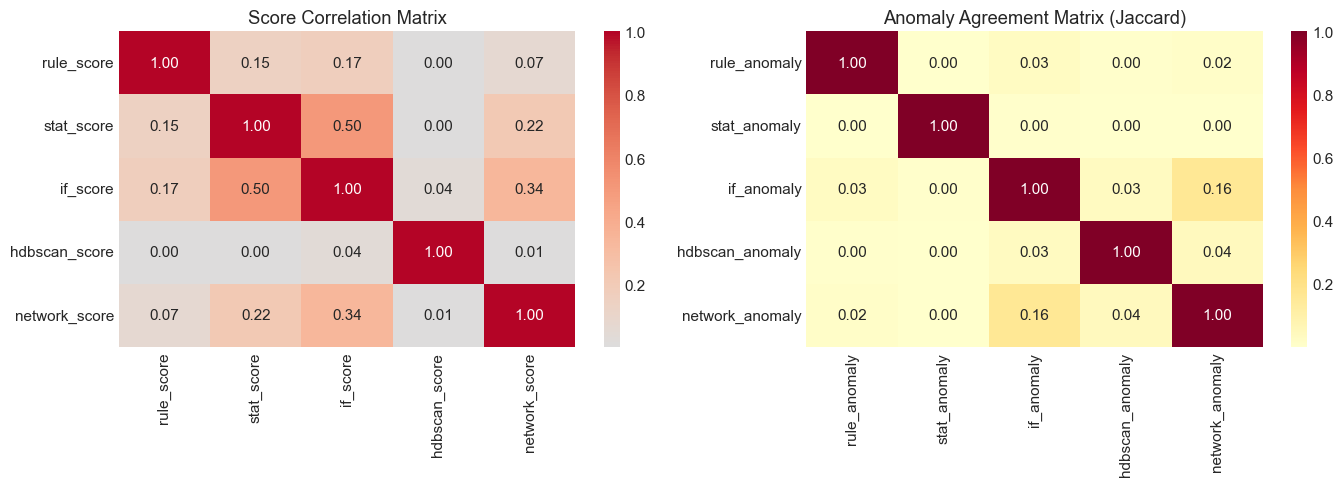

In [15]:
# Visualize agreement matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Score Correlation Matrix')

# Agreement heatmap (Jaccard)
ax = axes[1]
sns.heatmap(agreement_matrix.astype(float), annot=True, fmt='.2f', cmap='YlOrRd', ax=ax)
ax.set_title('Anomaly Agreement Matrix (Jaccard)')

plt.tight_layout()
plt.savefig('../results/figures/ensemble/method_agreement.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Critical Tenders Analysis

In [16]:
# Get critical tenders (using EnsembleDetector helper)
critical_tenders = ensemble_detector.get_critical_tenders()
normal_tenders = ensemble[ensemble['consensus_count'] == 0]

# Merge with tender details
critical_with_details = critical_tenders.merge(
    tenders[['tender_id', 'tender_value', 'is_single_bidder', 'is_competitive']],
    on='tender_id', how='left'
)
normal_with_details = normal_tenders.merge(
    tenders[['tender_id', 'tender_value', 'is_single_bidder', 'is_competitive']],
    on='tender_id', how='left'
)

print("="*60)
print("CRITICAL TENDERS CHARACTERISTICS")
print("="*60)

print(f"\n{'Metric':<30} {'Critical':>15} {'Normal':>15}")
print("-"*60)

# Value
c_mean = critical_with_details['tender_value'].mean()
n_mean = normal_with_details['tender_value'].mean()
print(f"{'Mean tender value (M UAH)':<30} {c_mean/1e6:>15,.2f} {n_mean/1e6:>15,.2f}")

c_med = critical_with_details['tender_value'].median()
n_med = normal_with_details['tender_value'].median()
print(f"{'Median tender value (K UAH)':<30} {c_med/1e3:>15,.1f} {n_med/1e3:>15,.1f}")

# Competition
c_sb = critical_with_details['is_single_bidder'].mean()
n_sb = normal_with_details['is_single_bidder'].mean()
print(f"{'Single bidder rate (%)':<30} {c_sb*100:>15.1f} {n_sb*100:>15.1f}")

c_comp = critical_with_details['is_competitive'].mean()
n_comp = normal_with_details['is_competitive'].mean()
print(f"{'Competitive rate (%)':<30} {c_comp*100:>15.1f} {n_comp*100:>15.1f}")

CRITICAL TENDERS CHARACTERISTICS

Metric                                Critical          Normal
------------------------------------------------------------
Mean tender value (M UAH)                16.79            0.11
Median tender value (K UAH)              449.1             4.0
Single bidder rate (%)                    65.8             1.8
Competitive rate (%)                      33.8             0.7


In [17]:
# Procurement method distribution
print("\nPROCUREMENT METHOD:")

# Merge with tenders to get procurement method
critical_methods = critical_tenders.merge(tenders[['tender_id', 'procurement_method']], on='tender_id')
normal_methods = normal_tenders.merge(tenders[['tender_id', 'procurement_method']], on='tender_id')

critical_method_dist = critical_methods['procurement_method'].value_counts(normalize=True) * 100
normal_method_dist = normal_methods['procurement_method'].value_counts(normalize=True) * 100

for method in critical_method_dist.index:
    c_pct = critical_method_dist.get(method, 0)
    n_pct = normal_method_dist.get(method, 0)
    ratio = c_pct / n_pct if n_pct > 0 else 0
    print(f"  {method}: {c_pct:.1f}% (vs {n_pct:.1f}% normal) - {ratio:.1f}x")


PROCUREMENT METHOD:
  open: 73.1% (vs 2.1% normal) - 34.4x
  selective: 26.4% (vs 0.3% normal) - 81.2x
  limited: 0.5% (vs 97.5% normal) - 0.0x


In [18]:
# Year distribution
print("\nYEAR DISTRIBUTION:")

critical_years = critical_tenders.merge(tenders[['tender_id', 'year']], on='tender_id')
critical_year_dist = critical_years['year'].value_counts().sort_index()

for year, count in critical_year_dist.items():
    total_year = len(tenders[tenders['year'] == year])
    pct = count / total_year * 100
    print(f"  {year}: {count:,} ({pct:.2f}% of year)")


YEAR DISTRIBUTION:
  2022: 85 (0.00% of year)
  2023: 109 (0.00% of year)
  2024: 203 (0.01% of year)
  2025: 231 (0.01% of year)


## 9. Top Risky Entities

In [19]:
# Top buyers by critical tender count
print("TOP 10 BUYERS BY CRITICAL TENDERS:")

critical_full = critical_tenders.merge(
    tenders[['tender_id', 'buyer_id', 'supplier_id', 'tender_value']], 
    on='tender_id', how='left'
)

top_buyers_critical = critical_full.groupby('buyer_id').agg({
    'tender_id': 'count',
    'tender_value': 'sum',
    'ensemble_score': 'mean'
}).sort_values('tender_id', ascending=False).head(10)

top_buyers_critical = top_buyers_critical.reset_index().merge(
    buyers[['buyer_id', 'buyer_name', 'buyer_region']], on='buyer_id', how='left'
)

for _, row in top_buyers_critical.iterrows():
    name = str(row['buyer_name'])[:50] if pd.notna(row['buyer_name']) else 'N/A'
    print(f"  {row['tender_id']:>5,} tenders | {row['tender_value']/1e6:>10,.1f}M UAH | {name}")

TOP 10 BUYERS BY CRITICAL TENDERS:
     38 tenders |    3,818.6M UAH | Державне підприємство Міністерства оборони України
      6 tenders |        0.9M UAH | АКЦІОНЕРНЕ ТОВАРИСТВО "УКРПОШТА"
      6 tenders |        2.2M UAH | Департамент патрульної поліції
      5 tenders |       11.4M UAH | ФІЛІЯ "ПАСАЖИРСЬКА КОМПАНІЯ" АКЦІОНЕРНОГО ТОВАРИСТ
      5 tenders |        2.1M UAH | Комунальне некомерційне підприємство «Гайсинська ц
      5 tenders |        0.4M UAH | ВІЙСЬКОВА ЧАСТИНА 2253
      5 tenders |       65.0M UAH | БАЗА ЗАБЕЗПЕЧЕННЯ НАЦІОНАЛЬНОЇ ГВАРДІЇ УКРАЇНИ (ВІ
      5 tenders |       69.2M UAH | Приватне акціонерне товариство "Укргідроенерго"
      5 tenders |       11.0M UAH | КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО " ЛЬВІВСЬКЕ Т
      4 tenders |        1.7M UAH | КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДОБРОБУТ
ПОЛТАВСЬКОЇ ГРОМ


In [20]:
# Top suppliers by critical tender count
print("\nTOP 10 SUPPLIERS BY CRITICAL TENDERS:")

top_suppliers_critical = critical_full.groupby('supplier_id').agg({
    'tender_id': 'count',
    'tender_value': 'sum',
    'ensemble_score': 'mean'
}).sort_values('tender_id', ascending=False).head(10)

top_suppliers_critical = top_suppliers_critical.reset_index().merge(
    suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
)

for _, row in top_suppliers_critical.iterrows():
    name = str(row['supplier_name'])[:50] if pd.notna(row['supplier_name']) else 'N/A'
    print(f"  {row['tender_id']:>5,} tenders | {row['tender_value']/1e6:>10,.1f}M UAH | {name}")


TOP 10 SUPPLIERS BY CRITICAL TENDERS:
     16 tenders |       59.2M UAH | ТОВ "СТМ-Фарм"
     12 tenders |        1.8M UAH | Невідокремлений структурний підрозділ ТОВ "Епіцент
      9 tenders |        2.9M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛР"
      9 tenders |       11.9M UAH | Товариство з обмеженою відповідальністю "Медичний 
      9 tenders |       13.5M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАУНЧ УКР
      8 tenders |       96.2M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСТРАКШ
      8 tenders |       17.0M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРТЛАЙН І
      8 tenders |      581.8M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІВСЬК
      7 tenders |    1,025.4M UAH | ТОВ "МІК"
      7 tenders |        0.7M UAH | Товариство з обмеженою відповідальністю  "Радивилі


## 10. Save Results

In [21]:
# Save ensemble results
print("Saving results...")

# Define output columns
score_cols = [col for col in ensemble.columns if 'score' in col]
anomaly_cols = [col for col in ensemble.columns if 'anomaly' in col]
output_cols = ['tender_id'] + score_cols + anomaly_cols + ['consensus_count', 'consensus_pct', 'ensemble_risk_level']

# Save full results
ensemble[output_cols].to_csv('../results/ensemble_results.csv', index=False)
print(f"Saved full results: results/ensemble_results.csv ({len(ensemble):,} rows)")

# Save critical only
critical_tenders[output_cols].to_csv('../results/critical_tenders.csv', index=False)
print(f"Saved critical tenders: results/critical_tenders.csv ({len(critical_tenders):,} rows)")

# Save summary
summary = ensemble_detector.summary()
summary.to_csv('../results/ensemble_summary.csv', index=False)
print(f"Saved summary: results/ensemble_summary.csv")

Saving results...
Saved full results: results/ensemble_results.csv (12,877,960 rows)
Saved critical tenders: results/critical_tenders.csv (628 rows)
Saved summary: results/ensemble_summary.csv


## 11. Summary

In [22]:
print("="*60)
print("ENSEMBLE SUMMARY")
print("="*60)

print(f"\nDataset: {len(ensemble):,} tenders ({YEARS[0]}-{YEARS[-1]})")
print(f"\nMethods combined ({len(ensemble_detector.methods_used)}):")
for method in ensemble_detector.methods_used:
    anomaly_col = f"{method}_anomaly"
    if anomaly_col in ensemble.columns:
        count = ensemble[anomaly_col].sum()
        print(f"  {method}: {count:,} anomalies")

print(f"\nENSEMBLE RISK LEVELS:")
for level in ['critical', 'high', 'medium', 'low']:
    count = risk_dist.get(level, 0)
    pct = count / len(ensemble) * 100
    print(f"  {level:10} {count:>10,} ({pct:>5.2f}%)")

print(f"\nCRITICAL TENDERS (ensemble_risk_level == 'critical'):")
print(f"  Count: {len(critical_tenders):,}")
if len(critical_with_details) > 0:
    print(f"  Total value: {critical_with_details['tender_value'].sum()/1e9:.2f}B UAH")
    print(f"  Mean value: {critical_with_details['tender_value'].mean()/1e6:.2f}M UAH")
    print(f"  Single bidder rate: {critical_with_details['is_single_bidder'].mean()*100:.1f}%")

print("\n" + "="*60)

ENSEMBLE SUMMARY

Dataset: 12,877,960 tenders (2022-2025)

Methods combined (5):
  rule: 95,922 anomalies
  stat: 4,296 anomalies
  if: 643,898 anomalies
  hdbscan: 609,171 anomalies
  network: 2,296,664 anomalies

ENSEMBLE RISK LEVELS:
  critical          628 ( 0.00%)
  high           36,358 ( 0.28%)
  medium        507,278 ( 3.94%)
  low        12,333,696 (95.77%)

CRITICAL TENDERS (ensemble_risk_level == 'critical'):
  Count: 628
  Total value: 10.55B UAH
  Mean value: 16.79M UAH
  Single bidder rate: 65.8%



## Висновки

### Ensemble підхід (5 методів):
- **Rule-based** — процедурні порушення (44 rules)
- **Statistical** — числові аномалії (Benford, Z-score, HHI)
- **Isolation Forest** — глобальні outliers
- **HDBSCAN** — кластеризація + outlier detection
- **Network Analysis** — картелі, монополії, bid rotation

### Scoring:
- **Weighted score**: зважена комбінація нормалізованих scores
- **Consensus voting**: кількість методів, що flagged тендер
- **Risk levels**: critical (>=75%), high (>=50%), medium (>=25%), low (<25%)

### Ключові результати:
- **Critical** (більшість методів згодні) — найвища впевненість для аудиту
- Методи доповнюють один одного (низька кореляція)
- Різні типи аномалій покриваються різними методами

### Збережені файли:
- `results/ensemble_results.csv` — всі тендери з scores
- `results/critical_tenders.csv` — лише critical
- `results/ensemble_summary.csv` — summary statistics

### EnsembleDetector:
```python
from src.detectors import EnsembleDetector

detector = EnsembleDetector(consensus_threshold=2)
results = detector.combine(
    rule_results=...,
    stat_results=...,
    if_results=...,
    hdbscan_results=...,
    network_results=...,
)

critical = detector.get_critical_tenders()
print(detector.summary())
```